In [111]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import datetime as dt
from  scipy.stats import chisquare
from scipy.stats import chi2_contingency


# stats tests 
from scipy.stats import ttest_ind

# ml imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [3]:
# read in the data
data = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])

### Initial data cleaning
###### For details see other notebooks

In [6]:
# filter out negative age
data = data[data.Age >=0]

# This turns the No-show variable into a binary of true or false where true means a no-show.  
data['no_show_bi'] = data["No-show"]== 'Yes'

# Create a column that is the day of the week of the appointment 
data["appointment_day"] = data["AppointmentDay"].dt.weekday_name

# Remove the Saturday appointments as they are clearly outliers. 
data= data[data["appointment_day"] != "Saturday"]

# create a column for the time between when a patient scheduled the appointment to the appointment.
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date)

# drop negative wait time rows. 
data = data[data['wait'] >= "0 days"]

# remove outlier neighbourhoods
remove_list = ["ILHA DO BOI", "ILHA DO FRADE", "AEROPORTO", "ILHAS OCEÂNICAS DE TRINDADE","PARQUE INDUSTRIAL"]
data= data[~data.Neighbourhood.isin(remove_list)]

## Implement Binning System 
### Age Binning

In [18]:
def bin_age(df):
    '''Creates a function to turn age into 6 groups of binned ages.'''
                        # bin ranges 0-3, 4-7, 8-27, 28-40, 41-60, 61 < 
    if df["Age"] <4:
        return 2
    elif df["Age"] <8:
        return 5
    elif df["Age"] <28:
        return 16
    elif df["Age"] <41:
        return 34
    elif df["Age"] <61:
        return 51
    else:
        return 70

In [19]:
# apply binning function
data["Age_Binned"]= data.apply(bin_age, axis=1)

### Wait time binning

In [21]:
# turn wait time from time delta to an int
data["days_waiting"] = data["wait"].dt.days

In [22]:
def bin_wait_time(df):
    '''Creates a function to turn wait_time into 5 groups of binned wait times .'''
                        # bin ranges 0, 1, 2-4, 5-9, 10 < 
    col="days_waiting"
    if df[col]   <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <5:
        return 3
    elif df[col] <10:
        return 7
    else:
        return 15

In [23]:
# Apply the binning function. 
data["Wait_Binned"]= data.apply(bin_wait_time, axis=1)

# MACHINE LEARNING SECTION

Mentor notes: 
+ need to get data into correct format 
+ split / cross validation change –  logistic regression cv. 
+ create a machine learning pipeline -  MLP 
+ logistic regression. – over sampled / undersampled  ROV curve area under curve Grid search. 
+ knn
+ Random forest 
+ SVM - support vector machine 
+ Get some results full machine learning from begining to end. 


In [25]:
data.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'no_show_bi', 'appointment_day', 'wait', 'Age_Binned', 'days_waiting',
       'Wait_Binned'],
      dtype='object')

In [26]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,no_show_bi,appointment_day,wait,Age_Binned,days_waiting,Wait_Binned
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,False,Friday,0 days,70,0,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,False,Friday,0 days,51,0,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,False,Friday,0 days,70,0,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,False,Friday,0 days,16,0,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,False,Friday,0 days,51,0,0


## Wrangle the data into a form where ml can be applied

#### Run only one of the next two cells. 

In [27]:
# Run cell to run ML on all statistically significant predictor variables. 
X_create= data.set_index("AppointmentID")[['Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes','SMS_received','appointment_day', 'Age_Binned', 'Wait_Binned']]
X_create["Age_Binned"]=X_create["Age_Binned"].astype(str)
X_create["Wait_Binned"]=X_create["Wait_Binned"].astype(str)

y_create = data.set_index("AppointmentID")[["No-show"]]
y_create["No-show"][y_create["No-show"]=="Yes"] = 1
y_create["No-show"][y_create["No-show"]=="No"]  = 0

X_create.head()

,Neighbourhood,Scholarship,Hipertension,Diabetes,SMS_received,appointment_day,Age_Binned,Wait_Binned
AppointmentID,,,,,,,,
5642903,JARDIM DA PENHA,0,1,0,0,Friday,70,0
5642503,JARDIM DA PENHA,0,0,0,0,Friday,51,0
5642549,MATA DA PRAIA,0,0,0,0,Friday,70,0
5642828,PONTAL DE CAMBURI,0,0,0,0,Friday,16,0
5642494,JARDIM DA PENHA,0,1,1,0,Friday,51,0


In [66]:
# Run cell to run ML on only the best predictor variables.
X_create= data.set_index("AppointmentID")[["SMS_received","Age_Binned", "Wait_Binned","Neighbourhood"]]
X_create["Age_Binned"]=X_create["Age_Binned"].astype(str)
X_create["Wait_Binned"]=X_create["Wait_Binned"].astype(str)
y_create = data.set_index("AppointmentID")[["No-show"]]
y_create["No-show"][y_create["No-show"]=="Yes"] = 1
y_create["No-show"][y_create["No-show"]=="No"]  = 0
X_create.head()

,SMS_received,Age_Binned,Wait_Binned,Neighbourhood
AppointmentID,,,,
5642903,0,70,0,JARDIM DA PENHA
5642503,0,51,0,JARDIM DA PENHA
5642549,0,70,0,MATA DA PRAIA
5642828,0,16,0,PONTAL DE CAMBURI
5642494,0,51,0,JARDIM DA PENHA


In [67]:
X = pd.get_dummies(X_create, drop_first=True).values
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [68]:
# This puts the y values which are our targets into the correct format for ml 
y = np.array(list(y_create["No-show"]))
y

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

### Logistic Regression 

In [50]:
# run with all variables.  -- slightly slightly better AUC_ROC max than with the top variables. 
searchCV = LogisticRegressionCV(cv=4)
searchCV.fit(X_train, y_train)
y_pred_LR = searchCV.predict(X_test)
print ('Max auc_roc:', searchCV.scores_[1].max())

Max auc_roc: 0.798143536337


In [51]:
print(classification_report(y_test, y_pred_LR))
# We have predicted 0 no-shows with Logistic Regression

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     17621
          1       0.00      0.00      0.00      4465

avg / total       0.64      0.80      0.71     22086



C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
# does not work. 
y_pred_prob = searchCV.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

ValueError: X has 85 features per sample; expecting 92

In [57]:
print(y_pred_LR[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [53]:
print(y_test[:100])

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0]


In [ ]:
# run with all variables. 
searchCV.score(X_test,y_test)

In [ ]:
# run with top variables. 
searchCV = LogisticRegressionCV(cv=10)
searchCV.fit(X_train, y_train)
print ('Max auc_roc:', searchCV.scores_[1].max())

In [ ]:
# run with top variables. 
searchCV.score(X_test,y_test)

#### Trying to Implement ml pipeline 

#### from DATA CAMP FOR AN EXAMPLE. #### 
######  Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]
        
######  Create the pipeline: pipeline
pipeline = Pipeline(steps)

######  Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

###### Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(X_train,y_train)

###### Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = KNeighborsClassifier().fit(X_train, y_train)

2nd EXAMPLE from DATA CAMP 
#####  Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

##### Specify the hyperparameter space

parameters = {'SVM__C':[1, 10, 100], 'SVM__gamma':[0.1, 0.01]}

#####  Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2 , random_state=21)

#####  Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters)

##### Fit to the training set
cv.fit(X_train,y_train)

#####  Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

###### Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))

print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

## Impliment K-nearest neighbors Classifier

In [95]:
# run with the top variables 
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1 ).fit(X_train, y_train)
knn.score(X_test,y_test)
y_pred_knn = knn.predict(X_test)

In [99]:
# run with the top variables 
knn = KNeighborsClassifier(n_neighbors=18, n_jobs=-1 ).fit(X_train, y_train)
#knn.score(X_test,y_test)
y_pred_knn = knn.predict(X_test)

In [100]:
# scores with n-neighbors = 18
print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

          0       0.81      0.97      0.88     17621
          1       0.41      0.07      0.12      4465

avg / total       0.73      0.79      0.73     22086



In [102]:
# this is still a bad score on the training data 
knn.score(X_train, y_train)

0.79729454380801446

In [96]:
# scores with n-neighbors =4 
#print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

          0       0.81      0.95      0.87     17621
          1       0.36      0.11      0.16      4465

avg / total       0.72      0.78      0.73     22086



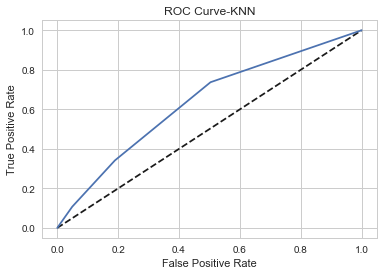

In [97]:
y_pred_prob = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-KNN')
plt.show()

### Grid Search to find best number of neighbors

In [98]:
param_grid = {'n_neighbors':np.arange(6,20)}
knn = KNeighborsClassifier(n_jobs=-1)
knn_cv = GridSearchCV(knn, param_grid, cv=3)
knn_cv.fit(X_train,y_train)
knn_cv.best_params_

{'n_neighbors': 18}

Best {'n_neighbors': 18} 6-20

Best {'n_neighbors': 4} - 3-5

In [101]:
knn_cv.best_score_

0.7931967398686891

## Support Vector Machine 

In [80]:
# this took a very long time to run... over 9000!!!!!!  ( Ben- what is wrong with this....? ) or does it just take minutes... 
# this is way slower than all the other ones. 
steps = [("SVM", SVC())]
pipeline= Pipeline(steps)
pipeline.fit(X_train, y_train)
# Predict the labels of the test set
y_pred_svm = pipeline.predict(X_test)

# Compute metrics
print(classification_report(y_test,y_pred_svm))

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     17621
          1       0.00      0.00      0.00      4465

avg / total       0.64      0.80      0.71     22086



C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### We have predicted 0 no-shows with SVM.

In [81]:
# ROC curve does not work. 
y_pred_prob = pipeline.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-KNN')
plt.show()

AttributeError: predict_proba is not available when  probability=False

## Random Forest Classifier

In [121]:
# run random forest 
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42) #, n_estimators=27, max_depth=15,  min_samples_leaf = 8)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7896404962419632

In [122]:
y_pred_RF = rfc.predict(X_test)

In [123]:
print(classification_report(y_test, y_pred_RF))

             precision    recall  f1-score   support

          0       0.80      0.97      0.88     17621
          1       0.39      0.07      0.12      4465

avg / total       0.72      0.79      0.73     22086



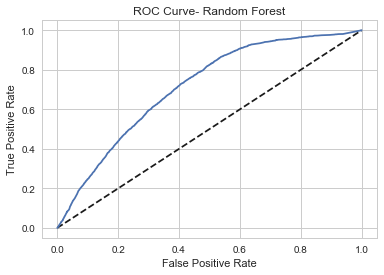

In [78]:
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

### Grid Search for Random Forest Hyperparameters 

In [134]:
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42) 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, scoring= metrics.make_scorer(metrics.f1_score) )
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, wa

KeyboardInterrupt: 

#### From above : {'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 27}

In [112]:
seed = 123

# Optimized RF classifier
rfc = RandomForestClassifier(n_estimators=27, max_depth=15,  min_samples_leaf = 8)

kfold = KFold(n_splits=5, random_state=seed)
cv_scores = []
cv_preds = []

# fit the model with training set
scores = cross_val_score(rfc, X_train, y_train, cv=kfold, scoring='accuracy')
cv_scores.append(scores.mean()*100)
print("Train accuracy %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))

# predict on testing set
preds = cross_val_predict(rfc, X_test, y_test, cv=kfold)
cv_preds.append(metrics.accuracy_score(y_test, preds)*100)
print("Test accuracy %0.2f" % (100*metrics.accuracy_score(y_test, preds)))

Train accuracy 79.81 (+/- 0.13)
Test accuracy 79.78


In [132]:
seed = 123

# Optimized RF classifier
rfc = RandomForestClassifier(n_estimators=27, max_depth=15,  min_samples_leaf = 8, random_state=42)

kfold = KFold(n_splits=5, random_state=seed)
cv_scores = []
cv_preds = []

# fit the model with training set
scores = cross_val_score(rfc, X_train, y_train, cv=kfold, scoring=metrics.make_scorer(metrics.f1_score))
cv_scores.append(scores.mean()*100)
print("Train accuracy %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))

# predict on testing set
preds = cross_val_predict(rfc, X_test, y_test, cv=kfold)
cv_preds.append(metrics.f1_score(y_test, preds)*100)
print("Test accuracy %0.2f" % (100*metrics.accuracy_score(y_test, preds)))

Train accuracy 0.67 (+/- 0.25)
Test accuracy 79.79


In [117]:
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     17621
          1       0.38      0.00      0.00      4465

avg / total       0.71      0.80      0.71     22086

